# Service Components

***
* Downloaded service-components data from the "market analysis" view. 
* "Components" column is the column that reflects what the organizations in the data set actually use a particular product for.
    * Renamed to "components_orgs_actually_use" to make this a little clearer.

In [1]:
import numpy as np
import pandas as pd

pd.options.display.max_columns = 64
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)
pd.options.display.float_format = "{:.2f}".format

from collections import Counter
from itertools import chain
from os import path

import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils
from calitp import *
from IPython.display import HTML, Image, Markdown, display, display_html
from PIL import Image
from shared_utils import altair_utils
from siuba import *

GCS_FILE_PATH = "gs://calitp-analytics-data/data-analyses/transit_stacks/"

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.


In [2]:
service_components = to_snakecase(
    pd.read_csv(f"{GCS_FILE_PATH}service-components-Market Analysis.csv")
)

In [3]:
len(service_components)

1032

In [4]:
service_components.dtypes

name                                                object
services                                            object
component                                           object
vendor__from_product_                               object
parent_organization__from_vendor___from_product_    object
provider__from_services_                            object
product                                             object
product_components                                  object
dtype: object

In [5]:
# Checking N/As
service_components.isna().sum()

name                                                  0
services                                              5
component                                             2
vendor__from_product_                                82
parent_organization__from_vendor___from_product_    785
provider__from_services_                              5
product                                               2
product_components                                   59
dtype: int64

In [6]:
# Fill in N/A and rename cols to be a little clearer.
service_components = service_components.fillna("N/A").rename(
    columns={
        "component": "components_orgs_actually_use",
        "product_components": "all_components_in_product",
    }
)

In [7]:
# Drop Duplicates
service_components = service_components.drop_duplicates()

In [8]:
display(
    Markdown(
        f"The length of the dataframe went down to {len(service_components)} after dropping duplicates"
        "<br>"
        f"There are {service_components.services.nunique()} different organizations."
        "<br>"
        f" There are {service_components.components_orgs_actually_use.nunique()} different components."
    )
)

The length of the dataframe went down to 1023 after dropping duplicates<br>There are 156 different organizations.<br> There are 26 different components.

In [9]:
# Copy dataframe to not mess the original one.
service_components2 = service_components.copy()

In [10]:
# Find if a value in "components_usage" matches a value in "all components in product" column because sometimes, they don't match.
# If there is at least one match, tag as "True."

# https://stackoverflow.com/questions/21514191/check-if-pandas-column-contains-value-from-another-column
service_components2["contained"] = service_components2.apply(
    lambda x: x.components_orgs_actually_use in x.all_components_in_product, axis=1
)

In [11]:
# Double check that this worked properly.
service_components2[
    [
        "services",
        "product",
        "components_orgs_actually_use",
        "all_components_in_product",
        "contained",
    ]
].sample(3)

,services,product,components_orgs_actually_use,all_components_in_product,contained
36,"SacRT Light Rail,e-van,SacRT GO,Elk Grove Transit Services,Folsom Stage Line,Causeway Connection,Sacramento Airport Express,SacRT Bus,SacRT Neighborhood Ride",Trapeze Fixed Route Scheduling,GTFS generation,"Run cutting,Driver Sign-up",False
380,"LA Metro Bus,LA Metro Rail",IBI Alerts,Alerts Content Management System,"Alerts Content Management System,Social Alerts,Alerts Subscription Service,GTFS Alerts Publication",True
158,Vine Transit,Remix Transit,Scheduling (Fixed-route),Network Planning,False


## Summarizing the DataFrame
***
* It looks like some services/organizations use the same product from the same vendor for 1+ components but this is split on 2 lines.
    * Example: Tuolumne County Transit uses Doublemap RealTime product for both real-time and arrival predictions. 
    * However, 'real-time' and 'arrival predictions' are split on  different lines, even though they reference the same product, vendor, and customer.
* Group/summarize so the same service-vendor-product combination on the same line to avoid duplicate entires.

In [12]:
# Copy dataframe to not mess the original one.
service_components3 = service_components2.copy()

In [13]:
# Group the column "components_orgs_actually_use" based on services/organizations, vendor, and product
service_components3["components_usage"] = service_components3.groupby(
    ["services", "vendor__from_product_", "product"]
)["components_orgs_actually_use"].transform(lambda x: ",".join(x))

In [14]:
# Sort dataframe by product and contained so the first "True" is kept.
service_components3 = service_components3.sort_values(
    by=["product", "contained"], ascending=False
)

In [15]:
# Drop certain duplicates
service_components3 = service_components3.drop_duplicates(
    subset=["services", "product", "vendor__from_product_", "components_usage"],
    keep="first",
)

In [16]:
# Keep only columns of interest
service_components3 = service_components3[
    [
        "services",
        "vendor__from_product_",
        "provider__from_services_",
        "parent_organization__from_vendor___from_product_",
        "product",
        "all_components_in_product",
        "components_usage",
        "contained",
    ]
]

In [17]:
# Double checking
service_components3[(service_components3.services.str.contains("Get Bus", case=False))]

,services,vendor__from_product_,provider__from_services_,parent_organization__from_vendor___from_product_,product,all_components_in_product,components_usage,contained
35,"GET Bus,GET Bus On Demand",Worldpay,"Golden Empire Transit District, Golden Empire Transit District",Fidelity National Information Services,Worldpay,Payment processor,Payment processor,True
944,GET Bus,N/A,Golden Empire Transit District,N/A,Vantiv,"Merchant services,Payment processor",Payment processor,True
2,"GET Bus,GET Bus On Demand",UTA,"Golden Empire Transit District, Golden Empire Transit District",N/A,UTA APC Software,APC Software,APC Software,True
1024,GET Bus,Transit App Inc.,Golden Empire Transit District,N/A,Transit Royale,"Mobile trip planning app,Alerts Subscription Service",Mobile trip planning app,True
58,"GET Bus,GET Bus On Demand",Transit App Inc.,"Golden Empire Transit District, Golden Empire Transit District",N/A,Transit App,Mobile trip planning app,Alerts Content Management System,False
8,"GET Bus,GET Bus On Demand",TransTrack Solutions Group,"Golden Empire Transit District, Golden Empire Transit District",N/A,TransTrack Manager,"Data Analysis/GIS/Modelling Software,KPI Reporting",KPI Reporting,True
949,GET Bus,TransTrack Solutions Group,Golden Empire Transit District,N/A,TransTrack Manager,"Data Analysis/GIS/Modelling Software,KPI Reporting",KPI Reporting,True
1,"GET Bus,GET Bus On Demand",Token Transit,"Golden Empire Transit District, Golden Empire Transit District",N/A,Token Transit Mobile Ticketing,Mobile ticketing,Mobile ticketing,True
96,"GET Bus,GET Bus On Demand",SunriseSESA,"Golden Empire Transit District, Golden Empire Transit District",N/A,Sunrise CDP,"General Signage ,Interior signage,Headsigns,Side signs",Offboard signage,False
17,"GET Bus,GET Bus On Demand",Optibus,"Golden Empire Transit District, Golden Empire Transit District",N/A,Optibus,"Scheduling (Fixed-route),GTFS Schedule Publishing,GTFS generation",Scheduling (Fixed-route),True


In [18]:
len(service_components3)

737

## Are there vendors that offer GTFS & Real Time that nobody is using?
***

* No. There are even more vendors in the service component dataset compared to the products data set.

In [19]:
# Filter out products that have GTFS and Scheduling in service components dataset
gtfs_rt = service_components[
    service_components["all_components_in_product"].str.contains("GTFS", case=False)
    & service_components["all_components_in_product"].str.contains(
        "real-time", case=False
    )
]

In [20]:
# Double check
# gtfs_rt

In [21]:
# Read in products data set
FILE_NAME = "transit_stacks.xlsx"
products = pd.read_excel(f"{GCS_FILE_PATH}{FILE_NAME}", sheet_name="products_clean")

In [22]:
# Filter out products that have GTFS and Scheduling in products dataset
products_gtfs_rt = products[
    products["components"].str.contains("GTFS", case=False)
    & products["components"].str.contains("real-time", case=False)
]

In [23]:
# Grab unique vendors and change it to a set
products_vendors = set(products_gtfs_rt.vendor.unique().tolist())
products_vendors

{'GMV Syncromatics Inc', 'Swiftly Inc.', 'TripShot Inc.', 'Uber Inc.'}

In [24]:
# Grab unique vendors and chane it to a set
service_comps_vendors = set(gtfs_rt.vendor__from_product_.unique().tolist())
service_comps_vendors

{'DoubleMap Inc.,Nixle',
 'GMV Syncromatics Inc',
 'Optibus,GMV Syncromatics Inc',
 'Swiftly Inc.',
 'Token Transit,Uber Inc.',
 'TripShot Inc.',
 'Uber Inc.',
 'Uber Inc.,Uber Inc.'}

In [25]:
products_vendors - service_comps_vendors

set()

## How many components are organizations actually using versus how many components a product actually offers?
***


In [26]:
# Number of components an organization uses that product for (clean this up with assign later)
# https://stackoverflow.com/questions/30202011/how-can-i-count-comma-separated-values-in-one-column-of-my-panda-table
service_components3["number_of_components_used"] = (
    service_components3["components_usage"]
    .apply(lambda x: len(x.split(",")))
    .astype("int64")
)
# Number of components available in the product
service_components3["number_of_components_avail"] = (
    service_components3["all_components_in_product"]
    .apply(lambda x: len(x.split(",")))
    .astype("int64")
)

# Dividing based
service_components3["percent_of_components_used"] = (
    service_components3["number_of_components_used"]
    / service_components3["number_of_components_avail"]
)

In [27]:
# Filter out for "falses' in contained - thinking it's better to exclude organizations that doesn't use a component listed in "all_components_in_product"
components_used = service_components3.loc[service_components3["contained"] == True]

In [28]:
f"There are {len(components_used)} trues"

'There are 458 trues'

In [29]:
# Group to by how many components available versus how many components are actually being used. Count organizations, but not with unique.
components_used2 = (
    components_used.groupby(["number_of_components_avail", "number_of_components_used"])
    .agg({"services": "nunique"})
    .rename(columns={"services": "Count of Organizations"})
)

In [30]:
components_used2.index.names = ["# of Components Available", "# of Components Used"]

In [31]:
display(
    Markdown(
        "Most organizations (105) use a product with only one component available anyway."
        "<br>"
        "The next most common combination: 2 components are available for a product, but only 1 product is used."
        "<br>"
        "Placer County uses Cubic Next Suite for 8 different tasks, hence the crazy skew."
    )
)

components_used2

Most organizations (105) use a product with only one component available anyway.<br>The next most common combination: 2 components are available for a product, but only 1 product is used.<br>Placer County uses Cubic Next Suite for 8 different tasks, hence the crazy skew.

Count of Organizations
# of Components Available # of Components Used                        
1                         1                                        105
                          2                                          8
                          3                                         11
                          5                                          2
                          7                                          2
                          8                                          1
2                         1                                         80
                          2                                         24
                          3                                          5
                          4                                          6
                          7                                          1
3                         1                                         11
                          2                                          4
                          3                                          1
4                         1                                         15
                          2                                          1
                          3                                          1
5                         1                                         10
                          2                                         14
6                         1                                         22
                          2                                          8
7                         1                                          1
                          2                                          1
8                         1                                          1
9                         1                                          2
10                        1                                          1
                          2                                          1

## Why are organizations only buying certain components but not others?
***
* Maybe look at it using "function group" in components dataset.


In [32]:
# Read in components data set
FILE_NAME = "transit_stacks.xlsx"
components = pd.read_excel(f"{GCS_FILE_PATH}{FILE_NAME}", sheet_name="components_clean")

In [33]:
components = components[['name','function_group','products']]

In [34]:
#Explode the dataframe
#https://stackoverflow.com/questions/50731229/split-cell-into-multiple-rows-in-pandas-dataframe
components2 = (components.set_index(['name','function_group'])
   .apply(lambda x: x.str.split(',').explode())
   .reset_index())               

In [35]:
merge3 = pd.merge(components2, service_components3, left_on = "products", right_on = "product", indicator = True, how = "right")

In [37]:
merge4 = merge3.drop_duplicates()

In [38]:
merge4._merge.value_counts()

both          1190
right_only      97
left_only        0
Name: _merge, dtype: int64

In [39]:
merge4 = merge4[(merge4['_merge']=='both') & (merge4['number_of_components_avail'] > 1)]

In [40]:
merge4 = merge4[['function_group','product','vendor__from_product_',
                 'services','parent_organization__from_vendor___from_product_',
                 'number_of_components_used','number_of_components_avail']]

In [62]:
merge4.groupby(['function_group','number_of_components_avail','number_of_components_used']).agg({"services":"nunique"})

services
function_group  number_of_components_avail number_of_components_used          
Backoffice      2                          1                                14
                4                          1                                 2
                                           2                                 1
                                           3                                 1
                6                          1                                 2
                                           2                                 1
                                           8                                 1
Fare collection 2                          1                                 6
                                           2                                 1
                                           3                                 2
                                           6                                 2
                3                          1                                 1
                6                          1                                 1
                                           2                                 1
                                           8                                 1
                8                          1                                 5
                                           2                                 1
IT              2                          1                                 1
Operations      2                          1                                 6
                                           2                                 2
                                           3                                 1
                                           4                                 2
                                           7                                 1
                3                          1                                 3
                                           3                                 1
                4                          1                                11
                                           2                                 3
                                           3                                 1
                5                          1                                 8
                                           2                                14
                6                          1                                18
                                           2                                 5
                8                          1                                 6
                                           2                                 1
                10                         2                                 1
Reporting       4                          1                                 4
                                           2                                 2
                5                          1                                 3
                                           2                                14
                10                         2                                 1
Rider Info      2                          1                                 1
                3                          1                                 1
                4                          1                                 2
Rider info      2                          1                                70
                                           2                                25
                                           3                                 5
                                           4                                 4
                3                          1                                10
                                           2                                 2
                                         

## Which components are organizations "buying twice" theoretically?
***

* Products can have multiple functions.
* Organizations buy multiple products. The products they buy can potentially have the same functions.
* Seeing which components are available to organizations more than once in the various products they have purchased.

Draft findings:
* 34 different organizations bought more than 1 product with real-time capabilities.
* 11 " " with offboard signage capabilities.
* 9 " " with scheduling (fixed-route) feature.

In [42]:
# Summarizing dataframe even more. For each service/organization, place ALL the products used, all components in a product, and all the components a service uses
services_products = (
    service_components3.groupby("services")["product"].apply(",".join).reset_index()
)

In [43]:
services_components_in_products = (
    service_components3.groupby("services")["all_components_in_product"]
    .apply(",".join)
    .reset_index()
)

In [44]:
services_components_used = (
    service_components3.groupby("services")["components_usage"]
    .apply(",".join)
    .reset_index()
)

In [45]:
# Merge the dataframes together on service
merge1 = pd.merge(services_products, services_components_in_products, on="services")
merge2 = pd.merge(merge1, services_components_used, on="services").rename(
    columns={
        "product": "products purchased",
        "all_components_in_product": "available components in the products",
        "components_usage": "components used",
    }
)

In [46]:
# Double check that we have the same number of orgs in merge2 as our original df.
merge2.services.nunique()

156

In [47]:
# Just double checking
merge2.sample(2)

,services,products purchased,available components in the products,components used
134,Tri-Valley Wheels,"Trapeze Traveler Experience,Trapeze Signage,Twin Vision,Trapeze Signage,Trapeze Fixed Route Scheduling,Trapeze Annunciator,Trapeze - Unspecified,Iris Irma Matrix,Genfare Farebox (Unspecified)","Real-time info,General Signage ,Offboard signage,Interior signage,General Signage ,Run cutting,Driver Sign-up,Annunciator,Scheduling (Fixed-route),GTFS generation,APC Sensors,Cash Farebox","Arrival predictions,Headsigns,Offboard signage,Interior signage,Scheduling (Fixed-route),GTFS generation,Annunciator,Mobile data terminal software,Real-time info,APC Software,Cash Farebox"
0,Alhambra Community Transit,"Twin Vision,GeoTab,Excel,DoubleMap RealTime,Diamond - Cash box","Offboard signage,Interior signage,Location Sensors,General Purpose Software,Real-time info,Mobile trip planning app,Cash Farebox","Headsigns,AVL Software,Scheduling (Fixed-route),Arrival predictions,Real-time info,Cash Farebox"


In [48]:
# Count frequency of components for duplicates
# https://stackoverflow.com/questions/51258419/append-number-of-times-a-string-occurs-in-pandas-dataframe-to-another-column
freq = (
    merge2["available components in the products"]
    .apply(lambda x: pd.Series(Counter(x.split(","))), 1)
    .fillna(0)
    .astype(int)
)

In [49]:
# Merging dataframe from above with freq df, just in case it could be useful.
merge3 = merge2.join(freq)

In [50]:
# Get value counts: such as "Offboard signage" appears only once in the "all componentss in product usage" 29 times. Offboard signage appears twice 6 times.
freq2 = freq.apply(lambda x: x.value_counts()).T.stack()

# Turn this into a dataframe
freq_df = (
    freq2.to_frame()
    .reset_index()
    .rename(
        columns={
            "level_0": "Component",
            "level_1": "Number of Times Duplicate Components Appears in Products",
            0: "Count of Services",
        }
    )
)

In [51]:
# Filter out ONLY if components appear 2 or more times in the 'all_components_in_product' col
freq_df[
    (freq_df["Number of Times Duplicate Components Appears in Products"] > 1)
].groupby(["Component"]).agg({"Count of Services": "sum"}).sort_values(
    "Count of Services", ascending=False
)

,Count of Services
Component,
Real-time info,34.00
Offboard signage,11.00
Scheduling (Fixed-route),9.00
Mobile ticketing,8.00
Mobile trip planning app,8.00
Cash Farebox,7.00
Interior signage,7.00
Headsigns,7.00
AVL Software,7.00


## Which components pop up the most frequently?
***
* Real time-info is the most common component organizations buy.
* When comparing the dataframe below with the most "common elements" from the <b>contracts</b> dataset (the graph below), the elements don't really match.

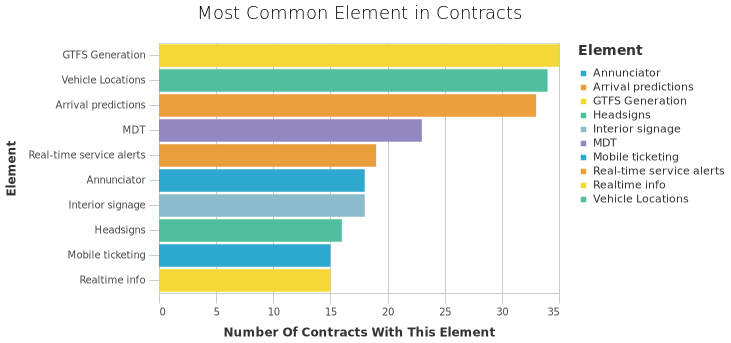

In [52]:

freq_df[
    (freq_df["Number of Times Duplicate Components Appears in Products"] > 0)
].groupby(["Component"]).agg({"Count of Services": "sum"}).sort_values(
    "Count of Services", ascending=False
).head(
    10
)

,Count of Services
Component,
Real-time info,110.00
Cash Farebox,87.00
GTFS generation,66.00
Mobile trip planning app,62.00
AVL Software,52.00
GTFS Schedule Publishing,47.00
Mobile ticketing,42.00
AVL On-board Computer,41.00
General Purpose Software,41.00


## Vendor x Component
***
* Looking at the vendor that has the most unique customers for a particular component.

In [53]:
vendor_comp = (
    service_components2.groupby(
        ["components_orgs_actually_use", "vendor__from_product_"]
    )
    .agg({"services": "nunique"})
    .rename(columns={"services": "Number of Customers"})
    .reset_index()
)

In [54]:
# Only keep the vendor with a particular component that is most popular.
# https://stackoverflow.com/questions/43899886/how-do-i-just-keep-the-rows-with-the-maximum-value-in-a-column-for-items-of-the
vendor_comp2 = vendor_comp.loc[
    vendor_comp.groupby("components_orgs_actually_use")["Number of Customers"].idxmax()
].rename(
    columns={
        "components_orgs_actually_use": "Component",
        "vendor__from_product_": "Most Frequent Vendor",
    }
)

In [55]:
vendor_comp2

,Component,Most Frequent Vendor,Number of Customers
0,APC Sensors,UTA,1
17,APC Software,UTA,12
20,AVL On-board Computer,Connexionz Inc.,1
31,AVL Software,GMV Syncromatics Inc,17
51,Alerts Content Management System,GMV Syncromatics Inc,7
68,Annunciator,GMV Syncromatics Inc,11
84,Arrival predictions,GMV Syncromatics Inc,17
92,Cash Farebox,Genfare,52
97,Contactless Payment Validators,Token Transit,2
98,Fare card system,Sacramento Area Council of Governments,5


In [56]:
vendor_freq = utils.value_counts_df(vendor_comp2, 'Most Frequent Vendor').rename(columns = {'index':'Vendor', 'Most Frequent Vendor':'Frequency'}).head(5)

In [57]:
utils.basic_bar_chart(
   vendor_freq,
    "Frequency",
    "Vendor",
    "Vendor",
    "Most Popular Vendors",
)

alt.Chart(...)

## Parent Company x Component
***

In [58]:
# As there are a lot of N/A for the parent org, filter out N/A
parent_comp = service_components2.loc[
    service_components2["parent_organization__from_vendor___from_product_"] != "N/A"
]

In [59]:
# Same thing as above
parent_comp2 = (
    parent_comp.groupby(
        [
            "components_orgs_actually_use",
            "parent_organization__from_vendor___from_product_",
        ]
    )
    .agg({"services": "nunique"})
    .rename(columns={"services": "Number of Customers"})
    .reset_index()
)

In [60]:
parent_comp3 = parent_comp2.loc[
    parent_comp2.groupby("components_orgs_actually_use")["Number of Customers"].idxmax()
].rename(
    columns={
        "components_orgs_actually_use": "Component",
        "parent_organization__from_vendor___from_product_": "Most Frequent Parent Organization",
    }
).reset_index()

In [61]:
parent_comp3

,index,Component,Most Frequent Parent Organization,Number of Customers
0,0,APC Software,GMV S.A.,7
1,3,AVL Software,GMV S.A.,18
2,7,Alerts Content Management System,GMV S.A.,7
3,11,Annunciator,GMV S.A.,11
4,14,Arrival predictions,GMV S.A.,18
5,18,GTFS generation,Modaxo Inc,12
6,20,Headsigns,GMV S.A.,7
7,23,Interior signage,GMV S.A.,9
8,27,KPI Reporting,Modaxo Inc,2
9,28,Mobile data terminal software,GMV S.A.,15
